In [7]:
from pennylane import numpy as np
import pennylane as qml
import tensorflow as tf

In [2]:
dev = qml.device('cirq.simulator', wires=3)

In [5]:
def real(angles, **kwargs):
    qml.Hadamard(wires=0)
    qml.Rot(*angles, wires=0)

In [6]:
def generator(w, **kwargs):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.RZ(w[8], wires=0)


def discriminator(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[0, 2])
    qml.RX(w[6], wires=2)
    qml.RY(w[7], wires=2)
    qml.RZ(w[8], wires=2)

In [12]:
@qml.qnode(dev)
def real_disc_circuit(phi, theta, omega, disc_weights):
    real([phi, theta, omega])
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

@qml.qnode(dev)
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

In [ ]:
real_wt = np.random.random(3)
gen_wt = np.random.random(9)
disc_wt = np.random.random(9)

(<Figure size 1900x400 with 1 Axes>, <Axes: >)

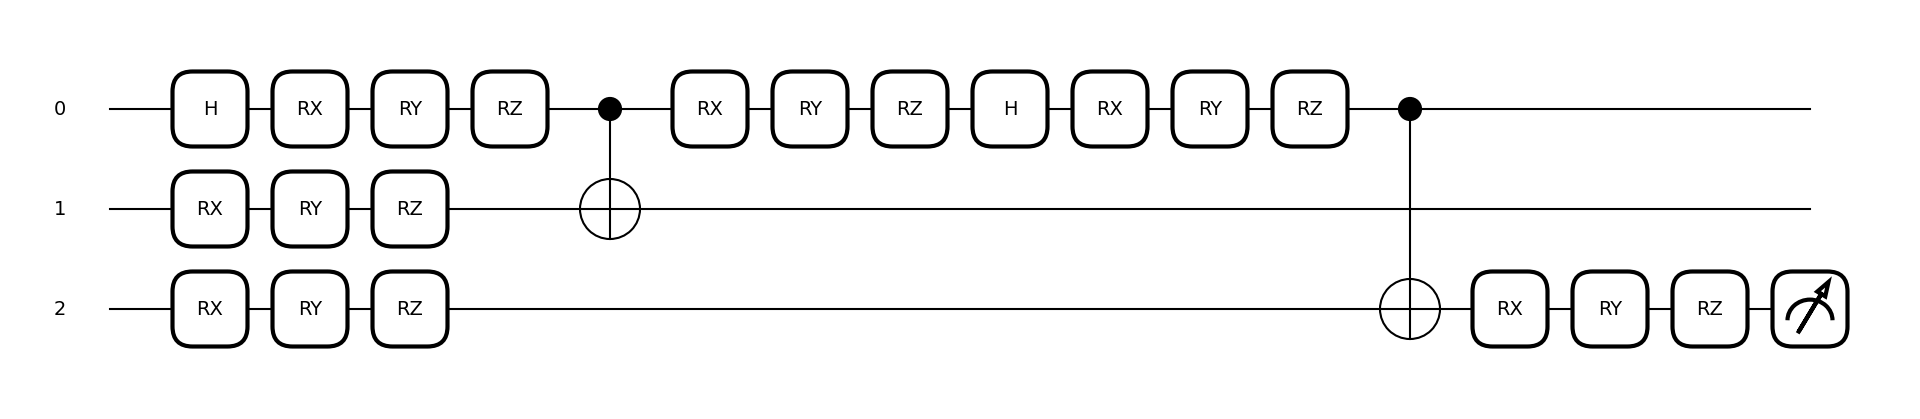

In [15]:
qml.draw_mpl(gen_disc_circuit)(gen_wt, disc_wt)

(<Figure size 1300x300 with 1 Axes>, <Axes: >)

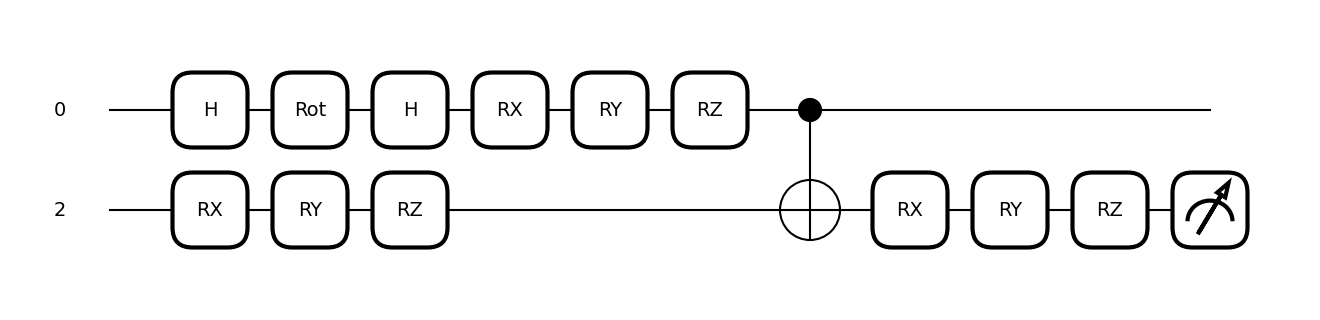

In [14]:
qml.draw_mpl(real_disc_circuit)(*real_wt, disc_wt)

In [16]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(phi, theta, omega, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights):
    return -prob_fake_true(gen_weights, disc_weights)

In [17]:
phi = np.pi / 6
theta = np.pi / 2
omega = np.pi / 7
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   np.random.normal(scale=eps, size=(9,))
init_disc_weights = np.random.normal(size=(9,))

gen_weights = tf.Variable(init_gen_weights)
disc_weights = tf.Variable(init_disc_weights)

In [20]:
opt = tf.optimizers.SGD(0.4)
opt.build([disc_weights, gen_weights])

In [33]:
# cost = lambda: disc_cost(disc_weights)

for step in range(50):
    # Compute the gradients.
    with tf.GradientTape() as tape:
        loss_value = disc_cost(disc_weights)
        
    # Update the variables.
    opt.apply_gradients(zip(tape.gradient(loss_value, [disc_weights]), [disc_weights]))
    
    if step % 5 == 0:
        cost_val = cost().numpy()
        print("Step {}: cost = {}".format(step, cost_val))

Step 0: cost = -0.05727693438529968
Step 5: cost = -0.26348117738962173
Step 10: cost = -0.42739173769950867
Step 15: cost = -0.4726158306002617
Step 20: cost = -0.4840691462159157
Step 25: cost = -0.4894638881087303
Step 30: cost = -0.49281882494688034
Step 35: cost = -0.49494923651218414
Step 40: cost = -0.4962702915072441
Step 45: cost = -0.4970718324184418


In [34]:
print("Prob(real classified as real): ", prob_real_true(disc_weights).numpy())

Prob(real classified as real):  0.9985871911048889


In [35]:
print("Prob(fake classified as real): ", prob_fake_true(gen_weights, disc_weights).numpy())

Prob(fake classified as real):  0.5011128857731819


In [36]:
for step in range(50):
    # Compute the gradients.
    with tf.GradientTape() as tape:
        loss_value = gen_cost(gen_weights)
    # Update the variables.
    opt.apply_gradients(zip(tape.gradient(loss_value, [gen_weights]), [gen_weights]))
    if step % 5 == 0:
        cost_val = cost().numpy()
        print("Step {}: cost = {}".format(step, cost_val))

Step 0: cost = -0.4152485504746437
Step 5: cost = -0.10701379179954529
Step 10: cost = -0.02016282081604004
Step 15: cost = -0.003938913345336914
Step 20: cost = -8.77678394317627e-05
Step 25: cost = 0.0009765923023223877
Step 30: cost = 0.0012846887111663818
Step 35: cost = 0.0013748705387115479
Step 40: cost = 0.0014014840126037598
Step 45: cost = 0.0014094114303588867


In [37]:
print("Prob(fake classified as real): ", prob_fake_true(gen_weights, disc_weights).numpy())

Prob(fake classified as real):  0.9999987483024597


In [38]:
print("Discriminator cost: ", disc_cost(disc_weights).numpy())

Discriminator cost:  0.0014115571975708008


In [39]:
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]

@qml.qnode(dev)
def bloch_vector_real(angles):
    real(angles)
    return [qml.expval(o) for o in obs]

@qml.qnode(dev)
def bloch_vector_generator(angles):
    generator(angles)
    return [qml.expval(o) for o in obs]

print(f"Real Bloch vector: {bloch_vector_real([phi, theta, omega])}")
print(f"Generator Bloch vector: {bloch_vector_generator(gen_weights)}")

Real Bloch vector: [array(-0.21694186), array(0.45048445), array(-0.86602533)]
Generator Bloch vector: [<tf.Tensor: shape=(), dtype=float64, numpy=-0.28404662013053894>, <tf.Tensor: shape=(), dtype=float64, numpy=0.4189322888851166>, <tf.Tensor: shape=(), dtype=float64, numpy=-0.8624440431594849>]


# Resources

- [QGAN - PennyLane](https://pennylane.ai/qml/demos/tutorial_QGAN/)